## Defense study - 2
This jupyter notebook creates plots to study the impact of upgrading/new stations near max waiting. 

*Plug count in (1:10)*

### 0. Analysis IDs to compare

In [80]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (125, 126 )

### 1. Package Installs

In [81]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [82]:
# Seaborn for plotting
#!pip install seaborn

In [83]:
#!pip install xarray

In [84]:
# Plotly for plotting 
#!pip install plotly

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
import xarray as xr
import plotly.data as pdata
from barchart3d import barchart3d
import math

### 2. Environment Variables

In [86]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [87]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [88]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [89]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [90]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [91]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [92]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,861,671
1,899,672
2,870,673
3,884,674
4,872,675
5,869,676
6,904,677
7,874,678
8,893,679
9,879,680


In [93]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,853,671
1,893,672
2,865,673
3,881,674
4,867,675
5,860,676
6,897,677
7,869,678
8,890,679
9,874,680


In [94]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,9,711
1,8,707
2,6,700
3,7,717
4,5,695
5,5,703
6,6,710
7,9,691
8,7,697
9,9,721


In [95]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,46.549913,-120.385234,672,0
1,48.204983,-119.008064,673,0
2,47.478669,-123.987695,675,0
3,47.039336,-123.081355,671,0
4,47.668887,-117.899296,673,0


In [96]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,100926.0,671
1,106000.0,672
2,96711.0,673
3,101722.0,674
4,100275.0,675
5,101688.0,676
6,106607.0,677
7,97258.0,678
8,102921.0,679
9,101107.0,680


In [97]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,564,671
1,569,672
2,540,673
3,577,674
4,537,675
5,575,676
6,576,677
7,548,678
8,597,679
9,554,680


In [98]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,23,700
1,29,695
2,77,677
3,20,698
4,26,699
5,25,714
6,23,709
7,22,718
8,25,712
9,83,679


In [99]:
# basecase_aid = 438
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,673,2019-07-01 06:00:06,0,0
1,672,2019-07-01 06:00:07,0,0
2,674,2019-07-01 06:00:10,0,0
3,675,2019-07-01 06:00:19,0,0
4,671,2019-07-01 06:00:38,0,0
...,...,...,...,...
53855,708,2019-07-01 22:28:06,0,5
53856,701,2019-07-01 22:28:38,0,5
53857,708,2019-07-01 22:29:06,0,5
53858,701,2019-07-01 22:29:38,0,5


In [100]:
sql_seeds = """select param_value as seed, analysis_id from analysis_params where analysis_id IN (select analysis_id from analysis_record where set_id = 125 order by analysis_id) and param_id = 1;"""
seeds = pd.read_sql_query(sql=sql_seeds, con=conn)['seed'].tolist()
# a_ids = a_ids[:-1]
seeds

['31', '386', '259', '420', '369']

In [101]:
sql_aids = """select analysis_id from analysis_record where set_id IN %s order by analysis_id"""
a_ids = pd.read_sql_query(sql=sql_aids, con=conn, params=(set_id,))['analysis_id'].tolist()
# a_ids = a_ids[:-1]
a_ids

[671,
 672,
 673,
 674,
 675,
 676,
 677,
 678,
 679,
 680,
 681,
 682,
 683,
 684,
 685,
 686,
 687,
 688,
 689,
 690,
 691,
 692,
 693,
 694,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 712,
 713,
 714,
 715,
 716,
 717,
 718,
 719,
 720,
 721,
 722,
 723,
 724,
 725]

In [102]:
basecase_aid = 484
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
order by ets.analysis_id desc
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,basecase_aid))
#count_stats.sort_values(by=['analysis_id'], inplace=True)
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,879,725,5,872,100899.0,7,551,23
1,893,724,5,890,102924.0,3,606,33
2,874,723,5,869,97259.0,5,555,18
3,904,722,5,896,106513.0,8,567,27
4,869,721,5,860,101675.0,9,567,21
5,879,720,5,873,101000.0,6,544,33
6,893,719,5,890,102907.0,3,600,23
7,874,718,5,869,97265.0,5,548,22
8,904,717,5,897,106632.0,7,581,24
9,869,716,5,860,101669.0,9,563,26


In [103]:
# count_stats.dtypes
# count_stats = count_stats.sort_values(by=['nevse_count'])
# count_stats

In [104]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2021-04-29 05:22:45.237232+00:00,671,2021-04-29 06:25:05.999102+00:00,2021-04-29 12:03:41.330214+00:00,# EV: 861,0,62.0,338.0
1,2021-04-29 05:22:48.438746+00:00,672,2021-04-29 06:26:32.783106+00:00,2021-04-29 12:34:34.266176+00:00,# EV: 899,0,63.0,368.0
2,2021-04-29 05:22:51.590769+00:00,673,2021-04-29 06:22:42.291101+00:00,2021-04-29 10:52:30.632950+00:00,# EV: 870,0,59.0,269.0
3,2021-04-29 05:22:54.742823+00:00,674,2021-04-29 06:18:45.903093+00:00,2021-04-29 11:04:21.068560+00:00,# EV: 884,0,55.0,285.0
4,2021-04-29 05:22:57.904371+00:00,675,2021-04-29 06:19:07.371218+00:00,2021-04-29 10:52:57.132768+00:00,# EV: 872,0,56.0,273.0
5,2021-04-29 05:27:24.255118+00:00,676,2021-04-29 06:58:23.275096+00:00,2021-04-29 13:26:05.319153+00:00,# EV: 869,5,90.0,387.0
6,2021-04-29 05:27:27.519100+00:00,677,2021-04-29 07:02:37.283093+00:00,2021-04-29 12:32:00.782519+00:00,# EV: 904,5,95.0,329.0
7,2021-04-29 05:27:30.711113+00:00,678,2021-04-29 06:57:41.785972+00:00,2021-04-29 12:27:44.301258+00:00,# EV: 874,5,90.0,330.0
8,2021-04-29 05:27:33.903107+00:00,679,2021-04-29 07:00:16.899089+00:00,2021-04-29 12:54:05.612458+00:00,# EV: 893,5,92.0,353.0
9,2021-04-29 05:27:37.099104+00:00,680,2021-04-29 06:57:38.371091+00:00,2021-04-29 12:53:23.640864+00:00,# EV: 879,5,90.0,355.0


## Find charging stations with max waiting sessions

In [105]:
basecase_aid = 484
sql_be_ws = """select count(wait_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_evs_waiting ews
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = ews.evse_id
where ews.analysis_id = 484
group by ews.analysis_id, ews.evse_id, be.latitude, be.longitude
order by count desc
limit 5;
"""
be_ws = pd.read_sql_query(sql=sql_be_ws, con=conn, params=(basecase_aid,))
be_ws.head()

,count,analysis_id,evse_id,latitude,longitude
0,27,484,b73433,47.420940,-121.411300
1,26,484,b167497,47.188833,-120.903139
2,13,484,b105362,47.467463,-120.336918
3,9,484,b99297,46.994236,-120.549197
4,7,484,b143835,46.679874,-122.977158


In [106]:
# sql_ne_ws = """select ne.latitude, ne.longitude, ne.analysis_id
# from new_evses ne
# where analysis_id IN ((select analysis_id from analysis_record where set_id = 106 limit 1)
#                       UNION
#                      (select analysis_id
#                       from analysis_record
#                       where set_id = 108
#                       limit 1));"""
#ne_ws = pd.read_sql_query(sql=sql_ne_ws, con=conn)
#ne_ws

### 5. Plotting

#### 5.1 Vehicle Counts

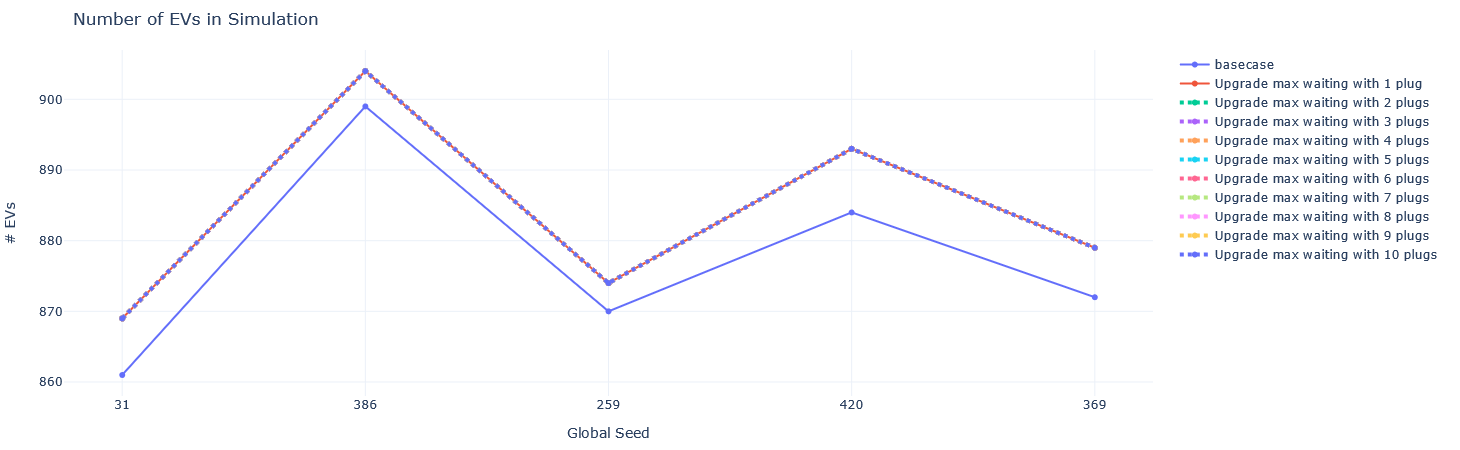

In [107]:
# EVs in simulation
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs in Simulation',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", )
fig.show()

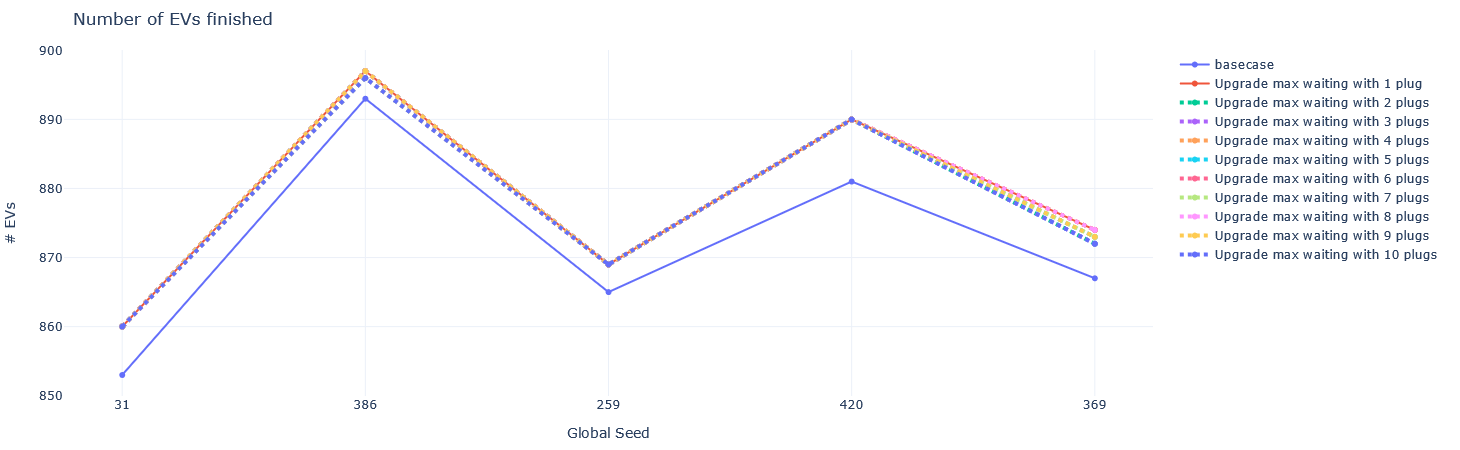

In [108]:
# EVs finished
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs finished',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", )
fig.show()

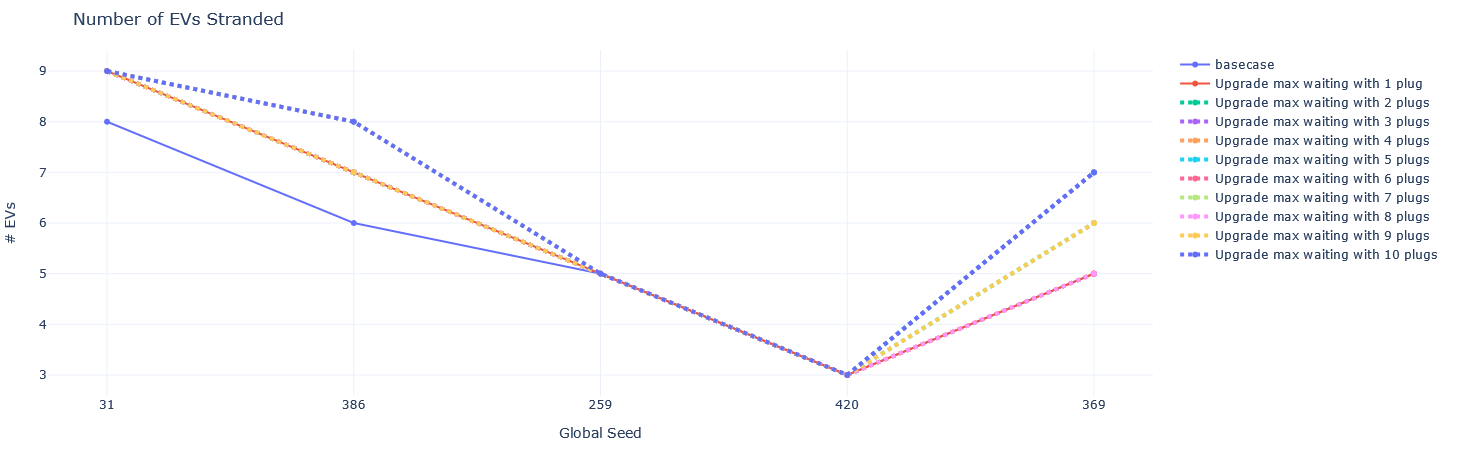

In [109]:
# EVs stranded
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of EVs Stranded',
        showlegend = True, yaxis_title="# EVs", 
                  xaxis_title="Global Seed", )
fig.show()

## 5.2 eVMT

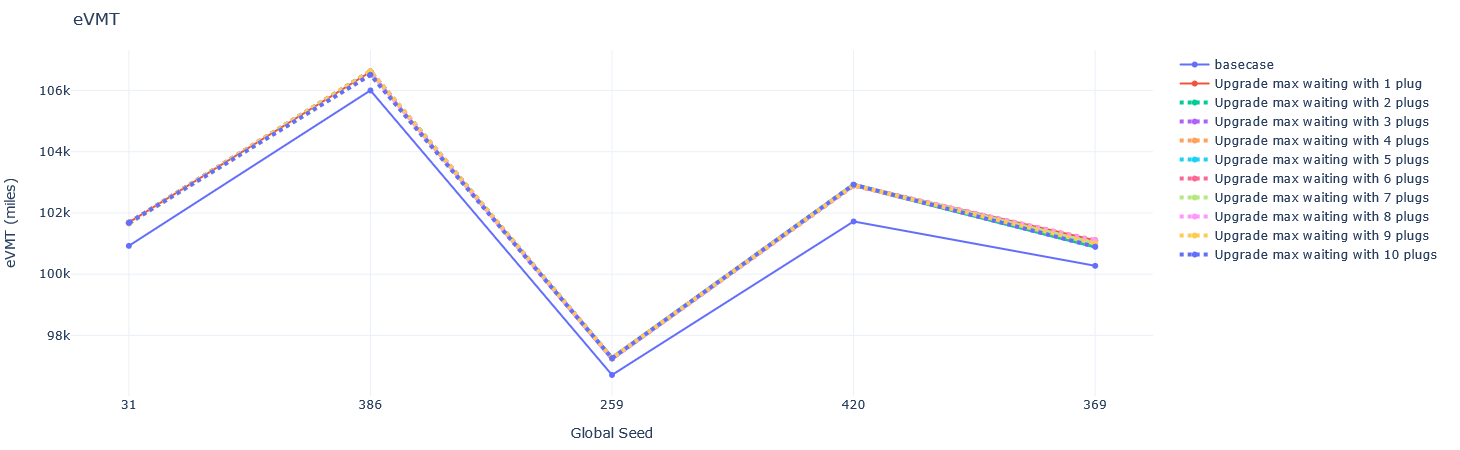

In [110]:
# evmt
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'eVMT',
        showlegend = True, yaxis_title="eVMT (miles)", 
                  xaxis_title="Global Seed", )
fig.show()

#### 5.3 Charging and Waiting Sessions

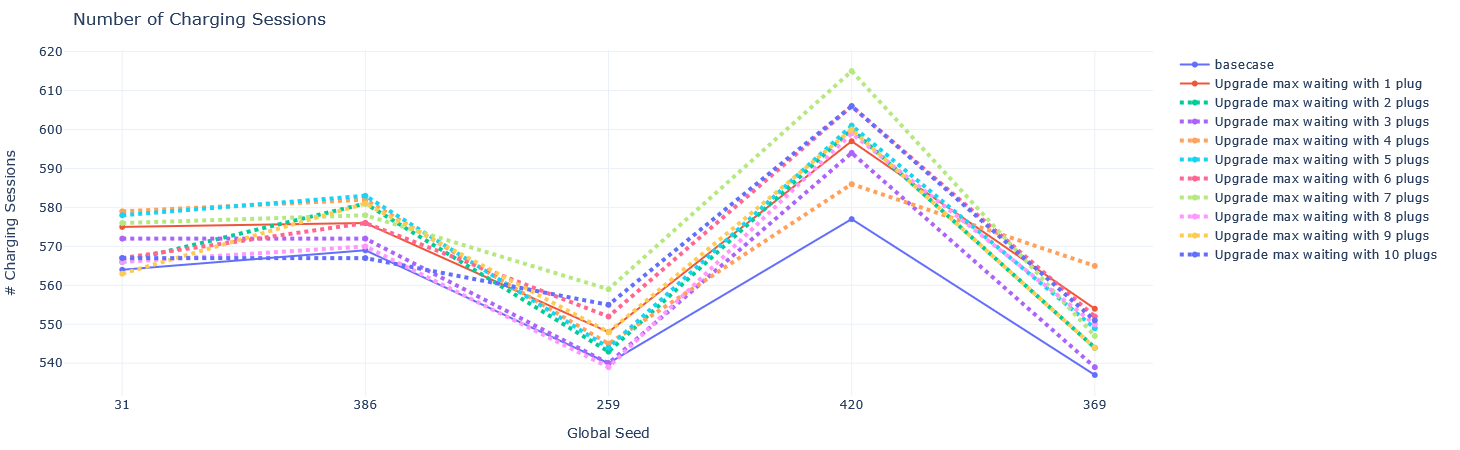

In [111]:
# charging_sessions count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of Charging Sessions',
        showlegend = True, yaxis_title="# Charging Sessions", 
                  xaxis_title="Global Seed", )
fig.show()

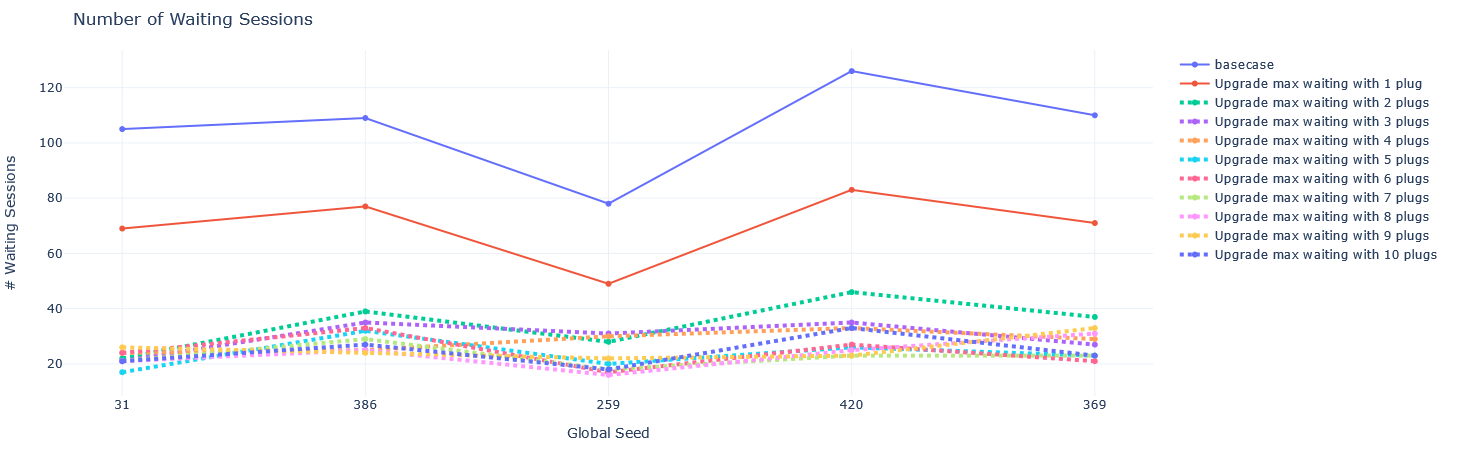

In [112]:
# waiting session count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(671 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 675)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(676 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 680)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 1 plug'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(681 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 685)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 2 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(686 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 690)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 3 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(691 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 695)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 4 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(696 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 700)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(701 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 705)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 6 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(706 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 710)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 7 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(711 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 715)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 8 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(716 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 720)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 9 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(721 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 725)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title_text = 'Number of Waiting Sessions',
        showlegend = True, yaxis_title="# Waiting Sessions", 
                  xaxis_title="Global Seed", )
fig.show()

In [37]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
# analysis_ids = new_evses['analysis_id'].unique()

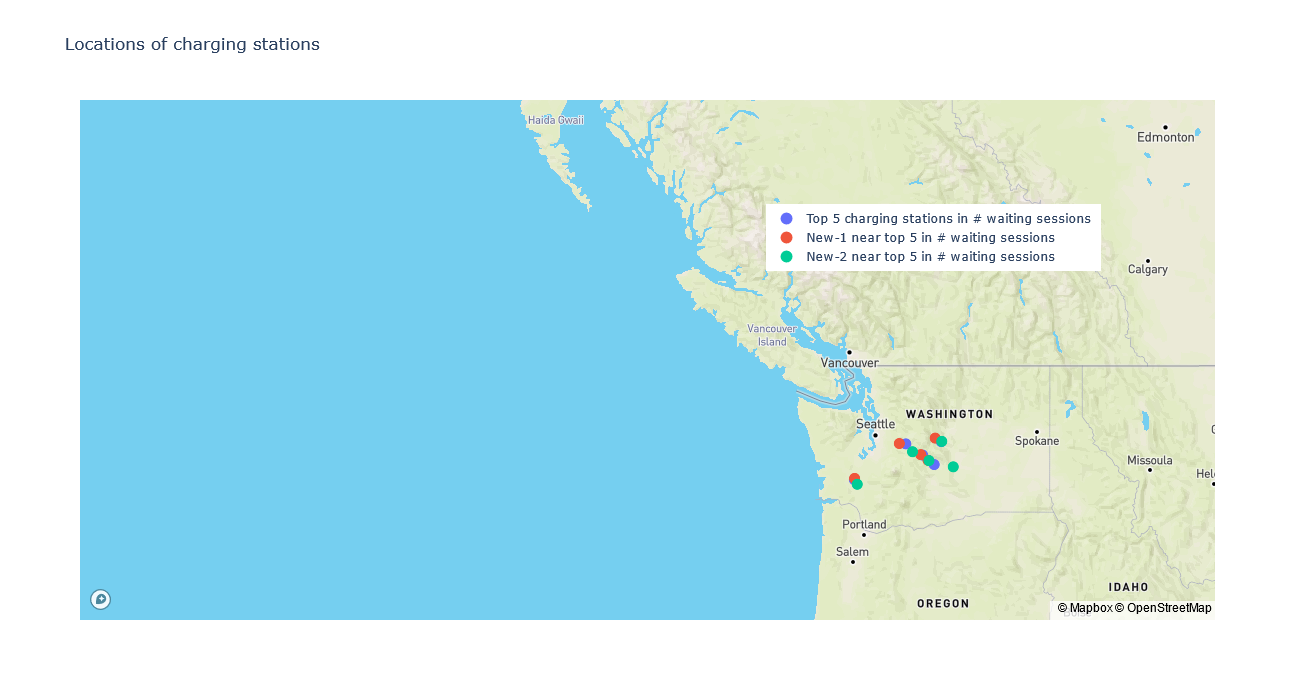

In [38]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=be_ws['latitude'],
        lon=be_ws['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='Top 5 charging stations in # waiting sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_ws[ne_ws['analysis_id'] == 520]['latitude'],
        lon=ne_ws[ne_ws['analysis_id'] == 520]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-1 near top 5 in # waiting sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_ws[ne_ws['analysis_id'] == 526]['latitude'],
        lon=ne_ws[ne_ws['analysis_id'] == 526]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-2 near top 5 in # waiting sessions'
    ))
fig.update_layout(
        title_text = 'Locations of charging stations',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

In [ ]:
a_ids

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [ ]:
#!jupyter labextension list

In [ ]:
#!jupyter labextension uninstall jupyterlab-plotly

In [ ]:
#!jupyter labextension uninstall plotlywidget

In [ ]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [ ]:
#!pip show plotly

In [ ]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [ ]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [ ]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [ ]:
#!pip install "nbconvert<6"